## 1. Import and visualize the data

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Text(0.5, 1.0, 'index=569, label=dog')

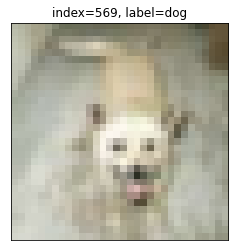

In [2]:
import numpy as np

index = np.random.randint(0, 1000)

plt.xticks([])
plt.yticks([])
plt.imshow(train_images[index])
plt.title(f"index={index}, label={class_names[train_labels[index][0]]}")

## 2. Handmade model

### 2.1 Create and train

In [3]:
model = models.Sequential()

# Conv layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# train
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

model.save('model_handmade')

Epoch 1/10
1563/1563 [==============================] - 33s 21ms/step - loss: 1.4809 - accuracy: 0.4611 - val_loss: 1.2023 - val_accuracy: 0.5664
Epoch 2/10
1563/1563 [==============================] - 32s 21ms/step - loss: 1.1130 - accuracy: 0.6073 - val_loss: 1.1229 - val_accuracy: 0.5989
Epoch 3/10
1563/1563 [==============================] - 33s 21ms/step - loss: 0.9719 - accuracy: 0.6585 - val_loss: 0.9508 - val_accuracy: 0.6648
Epoch 4/10
1563/1563 [==============================] - 33s 21ms/step - loss: 0.8751 - accuracy: 0.6934 - val_loss: 0.8895 - val_accuracy: 0.6885
Epoch 5/10
1563/1563 [==============================] - 33s 21ms/step - loss: 0.8077 - accuracy: 0.7181 - val_loss: 0.9102 - val_accuracy: 0.6816
Epoch 6/10
1563/1563 [==============================] - 32s 20ms/step - loss: 0.7495 - accuracy: 0.7361 - val_loss: 0.8694 - val_accuracy: 0.6961
Epoch 7/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.6960 - accuracy: 0.7572 - val_loss: 0.8573 -

INFO:tensorflow:Assets written to: model_handmade\assets


INFO:tensorflow:Assets written to: model_handmade\assets


313/313 [==============================] - 2s 6ms/step - loss: 0.9390 - accuracy: 0.6932


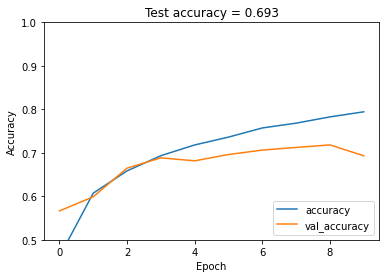

In [4]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title(f'Test accuracy = {test_acc:.3f}')
plt.legend(loc='lower right')

### 2.2 Visualize the predictions

In [5]:
probability_model = tf.keras.Sequential([model, layers.Softmax()])
predictions = probability_model.predict(test_images)

313/313 [==============================] - 2s 6ms/step


Text(0.5, 1.0, 'index=839, predicted=bird, actual=bird')

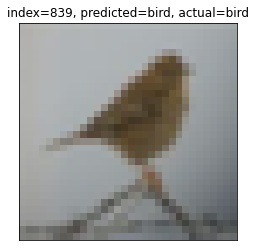

In [6]:
index = np.random.randint(0, 1000)

plt.xticks([])
plt.yticks([])
plt.imshow(test_images[index])
plt.title(f"index={index}, predicted={class_names[np.argmax(predictions[index])]}, actual={class_names[test_labels[index][0]]}")

### 2.3 Analyze the errors

In [7]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(predictions, axis=1)
y_true = test_labels.flatten()

cm = confusion_matrix(y_true, y_pred)

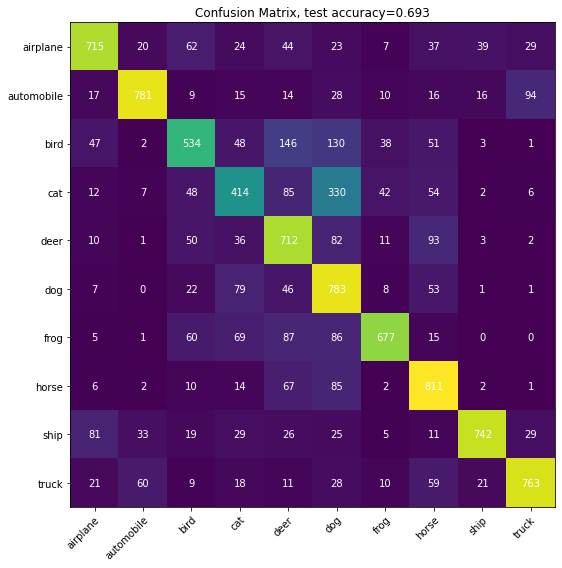

In [8]:
plt.rcParams['figure.figsize'] = [8, 8]

fig, ax = plt.subplots()
im = ax.imshow(cm)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title(f"Confusion Matrix, test accuracy={test_acc:.3f}")
fig.tight_layout()
plt.show()


We can see some legitimate errors, like taking a cat for a dog or a truck for an automobile.

### 3. Transfer Learning

In [9]:
from keras.applications import VGG19
from keras.utils import to_categorical

vgg = VGG19(include_top=False, weights='imagenet', input_shape=(32,32,3), classes=test_labels.shape[1])
vgg.trainable = False

model_transferred = models.Sequential()
model_transferred.add(vgg)
model_transferred.add(layers.Flatten())

model_transferred.add(layers.Dense(256, activation=('relu'), input_dim=512))
model_transferred.add(layers.Dense(128, activation='relu'))
model_transferred.add(layers.Dense(64, activation='relu'))
model_transferred.add(layers.Dense(32, activation='relu'))
model_transferred.add(layers.Dense(10))

model_transferred.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 10)               

In [10]:
# train
#model_transferred.compile(optimizer='adam',
#                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                        metrics=['accuracy'])

#history = model_transferred.fit(
#    train_images, train_labels, epochs=10, 
#    validation_data=(test_images, test_labels),
#    batch_size=128
#)

#model_transferred.save('model_transferred')

In [11]:
model_transferred = tf.keras.models.load_model('model_transferred', compile=False)
model_transferred.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

313/313 [==============================] - 38s 119ms/step


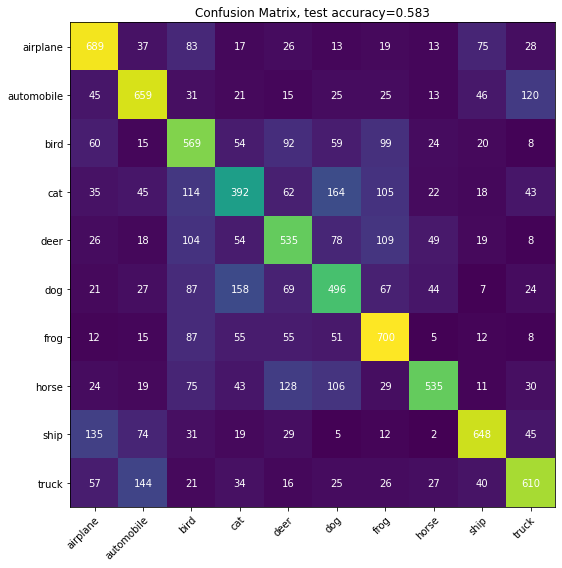

In [12]:
test_loss, test_acc = model_transferred.evaluate(test_images,  test_labels)

predictions = model_transferred.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
y_true = test_labels.flatten()

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title(f"Confusion Matrix, test accuracy={test_acc:.3f}")
fig.tight_layout()
plt.show()
